In [1]:
# # List all directories and files in the current working directory
# for root, dirs, files in os.walk('.'):
#     print("Root directory:", root)
#     print("Subdirectories:", dirs)
#     print("Files:", files)
#     break  # Stop after the first level to avoid printing too much

In [2]:
import os
os.chdir("../")    #commment after first run


In [3]:
#imports
import dask.distributed
import pystac_client
import planetary_computer
import stackstac 
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import geopandas as gpd
from src.utils import gen_chips


In [4]:
print(os.getcwd())
#should be /home/benchuser/code

/home/benchuser/code


In [5]:
#os.chdir("/home/benchuser/code")

In [6]:
#config setup
import yaml
with open("notebooks/config.yml", "r") as file:
    config = yaml.safe_load(file)
print(config)  # Check the structure of the dictionary


{'sentinel_2': {'collection': 'sentinel-2-l2a', 'time_ranges': ['2023-01-01/2023-03-31', '2023-04-01/2023-06-30', '2023-07-01/2023-09-30', '2023-10-01/2023-12-31'], 'cloud_cover': 1, 'bands': ['B2', 'B3', 'B4', 'B8', 'B11', 'B12'], 'resolution': 10}, 'land_cover': {'collection': 'io-lulc-annual-v02', 'year': '2023-01-02/2023-12-31'}, 'chips': {'sample_size': 100, 'chip_size': 224}, 'output': {'directory': 'notebooks/test_output_dump', 'naming_convention': 's2_{season}_{index:05}.tif'}, 'metadata': {'file': 'metadata.csv'}}


In [7]:
# Sentinel-2 settings
s2_collection = config["sentinel_2"]["collection"]
s2_date_ranges = config["sentinel_2"]["time_ranges"]
s2_bands = config["sentinel_2"]["bands"]
s2_resolution = config["sentinel_2"]["resolution"]
cloud_cover_threshold = config["sentinel_2"]["cloud_cover"]  # Max allowed cloud cover

# Land Cover settings
lc_collection = config["land_cover"]["collection"]
lc_year = config["land_cover"]["year"]  # Year of LC dataset

# Chip settings
sample_size = config["chips"]["sample_size"]  # Grid size for homogeneity check
chip_size = config["chips"]["chip_size"]  # Output chip size

# Output settings
output_dir = config["output"]["directory"]
chip_naming_convention = config["output"]["naming_convention"]

# Metadata settings
metadata_file = config["metadata"]["file"]

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define seasons for indexing
seasons = ["JFM", "AMJ", "JAS", "OND"]

aoi_gdf = gpd.read_file("data/urbans.geojson") # or "data/aois.geojson"


In [9]:
#dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


2025-02-11 01:53:42,791 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('fetch_raster_window-934478cf28471a2117ad44afa8e5a023', 3, 1, 3, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7efa5a3293a0>, (('asset_table_to_reader_and_window-fetch_raster_window-934478cf28471a2117ad44afa8e5a023', 3, 1, 3, 0),), {})
new run_spec: (subgraph_callable-b3e3b203da637e9766034190a9ae24b7, (('asset_table_to_reader_and_window-8d97af969a2bd9c7e720efc195ca0b14', 3, 1), (slice(3072, 4096, None), slice(0, 1024, None)), dtype('float64'), nan), {})
old token: ('tuple', (('913ceb5b5beb463a

In [26]:
def search_s2_scenes(aoi, date_range):
    print(f"Searching for Sentinel-2 scenes for AOI at {aoi.geometry.bounds} within {date_range}")
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    s2_search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=aoi.geometry.bounds, 
        datetime=date_range,
        query=["eo:cloud_cover<1"],
        sortby=["+properties.eo:cloud_cover"],
        max_items=1,
    )
    items = s2_search.item_collection()
    print(f"Found {len(items)} Sentinel-2 scenes")
    return list(items)  # Convert ItemCollection to a list of Items

def search_lc_scene(bbox, lc_date_range):
    print(f"Searching for Land Cover scenes within {lc_date_range} for bbox {bbox}")
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    lc_search = catalog.search(
        collections=["io-lulc-annual-v02"],
        bbox=bbox,
        datetime=lc_date_range,
    )
    items = lc_search.item_collection()
    print(f"Found {len(items)} Land Cover scenes")
    return list(items)  # Convert ItemCollection to a list of Items

def stack_s2_data(s2_items, s2_assets):
    if not s2_items:
        print("No Sentinel-2 items found.")
        return None
    
    try:
        print("Stacking Sentinel-2 images...")
        stacked_data = stackstac.stack(
            s2_items,
            assets=s2_assets,
            epsg=s2_items[0].properties["proj:epsg"],
            resolution=10,
            bounds_latlon=s2_items[0].bbox,
        ).median("time", skipna=True).squeeze()

        print("Stacked S2 data shape:", stacked_data.shape)

        if stacked_data is None or not isinstance(stacked_data, xr.DataArray):
            print("Error: Stacking Sentinel-2 data resulted in an invalid output.")
            return None

        stacked_data = stacked_data.chunk(chunks={"band": 6, "x": sample_size, "y": sample_size})
        return stacked_data

    except Exception as e:
        print(f"Error stacking Sentinel-2 data: {e}")
        return None

def stack_lc_data(lc_items, s2_epsg):
    if not lc_items:
        print("No Land Cover data found.")
        return None
    try:
        print("Stacking Land Cover images...")
        stacked_data = stackstac.stack(
            lc_items,
            dtype=np.ubyte,
            fill_value=255,
            sortby_date=False,
            epsg=s2_epsg,
            resolution=10,
            bounds_latlon=lc_items[0].bbox,
        ).squeeze()

        stacked_data = stacked_data.chunk(chunks={"x": sample_size, "y": sample_size})
        print("Stacked LC data shape:", stacked_data.shape)
        #print(f"Chunk sizes: {stacked_data.chunks}")   #uncomment for big chunk size 

        return stacked_data

    except Exception as e:
        print(f"Error stacking Land Cover data: {e}")
        return None


def has_missing_values(array):
    """Check if the given array contains NaN values and print only when necessary."""
    has_nan = array.isnull().any().compute()
    if has_nan:
        print("Warning: Missing values detected in the chip!")
    return has_nan


def process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict):
    print(f"Processing chips for AOI at {aoi.geometry.bounds}")

    # Ensure LC data matches Sentinel-2 CRS
    if s2_stack.rio.crs != lc_stack.rio.crs:
        print(f"Warning: LC and S2 have different CRS. Reprojecting LC to match S2...")
        lc_stack = lc_stack.rio.reproject(s2_stack.rio.crs)  

    # Check for all NaN values in the stack before iterating
    if s2_stack.isnull().all():
        print(f"Skipping AOI: s2_stack contains only NaN values.")
        return global_index  

    # Ensure LC stack is 3D by adding a 'band' dimension if missing
    if len(lc_stack.shape) == 2:
        print("Warning: lc_stack is 2D. Expanding dimensions to (1, height, width).")
        lc_stack = lc_stack.expand_dims(dim="band", axis=0)  # Adds a band dimension
    
    print(f"Updated LC stack shape: {lc_stack.shape}")  # Debugging output

    for i in range(0, lc_stack.shape[1] - chip_size, sample_size):
        for j in range(0, lc_stack.shape[2] - chip_size, sample_size):

            s2_chip = s2_stack.isel(x=slice(i, i + chip_size), y=slice(j, j + chip_size))
            lc_chip = lc_stack.isel(x=slice(i, i + chip_size), y=slice(j, j + chip_size))

            # Check for empty chips
            if s2_chip.size == 0 or lc_chip.size == 0:
                print(f"Skipping chip {global_index}: Empty dataset (NoDataInBounds)")
                continue  

            # Check for NaN values
            if s2_chip.isnull().all():
                print(f"Skipping chip {global_index}: All values are NaN.")
                continue  

            # Check for missing CRS
            if not hasattr(s2_chip, "rio") or s2_chip.rio.crs is None:
                print(f"Skipping chip {global_index}: Missing CRS (NoDataInBounds)")
                continue  

            # Check for valid transform
            if not hasattr(s2_chip, "rio") or s2_chip.rio.transform() is None:
                print(f"Skipping chip {global_index}: Missing spatial transform!")
                continue  

            # Debugging print statements
            print(f"Debugging chip {global_index}")
            print(f"s2_chip x range: {s2_chip.x.min().values} to {s2_chip.x.max().values}")
            print(f"s2_chip y range: {s2_chip.y.min().values} to {s2_chip.y.max().values}")
            print("S2 Chip CRS:", s2_chip.rio.crs)
            print("S2 Chip Bounds:", s2_chip.rio.bounds() if hasattr(s2_chip, "rio") else "No bounds")
            print("S2 Chip Transform:", s2_chip.rio.transform() if hasattr(s2_chip, "rio") else "No transform")

            # Save the chip
            chip_name = f"s2_{global_index:05}.tif"
            lc_chip.rio.to_raster(os.path.join(output_dir, f"lc_{chip_name}"))
            s2_chip.rio.to_raster(os.path.join(output_dir, chip_name))

            # Store chip in dictionary for visualization
            if (i, j) not in chip_dict:
                chip_dict[(i, j)] = []
            chip_dict[(i, j)].append((s2_chip, lc_chip))

            print(f"Saved chip {chip_name}")
            global_index += 1

    return global_index




In [27]:
global_index = 0
chip_dict = {}  # ✅ Initialize chip dictionary

for index, aoi in aoi_gdf.iterrows():
    print(f"Processing AOI {index}")

    # Search for Sentinel-2 images
    s2_items = [search_s2_scenes(aoi, date_range) for date_range in s2_date_ranges]
    s2_items = [item for sublist in s2_items for item in sublist]  # Flatten list

    if not s2_items:
        print(f"Skipping AOI {index}: No Sentinel-2 data found.")
        continue

    print(f"First S2 Item ID: {s2_items[0].id}")
    print(f"First S2 Item Properties: {s2_items[0].properties}")
    print(f"First S2 Item BBox: {s2_items[0].bbox}")

    # Stack Sentinel-2 images
    s2_stack = stack_s2_data(s2_items, s2_bands)
    if s2_stack is None:
        print(f"Skipping AOI {index}: No valid Sentinel-2 data found.")
        continue

    if not hasattr(s2_stack, "rio") or s2_stack.rio.crs is None:
        print(f"⚠️ Error: s2_stack is missing CRS information. Assigning manually.")
        s2_epsg = s2_items[0].properties["proj:epsg"]
        s2_stack.rio.write_crs(f"epsg:{s2_epsg}", inplace=True)

    print(f"✅ Sentinel-2 CRS: {s2_stack.rio.crs}")

    # Search for Land Cover images
    lc_items = search_lc_scene(s2_items[0].bbox, lc_year)
    if not lc_items:
        print(f"Skipping AOI {index}: No valid LC data found.")
        continue

    print(f"First LC Item BBox: {lc_items[0].bbox}")

    # Stack Land Cover images
    lc_stack = stack_lc_data(lc_items, s2_stack.rio.crs.to_epsg())
    if lc_stack is None:
        print(f"Skipping AOI {index}: No valid LC data found.")
        continue

    # Process chips (Now stores results in chip_dict)
    global_index = process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict)

    # Debugging: Stop after one AOI to check outputs
    break  



Processing AOI 0
Searching for Sentinel-2 scenes for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) within 2023-01-01/2023-03-31
Found 1 Sentinel-2 scenes
Searching for Sentinel-2 scenes for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) within 2023-04-01/2023-06-30
Found 1 Sentinel-2 scenes
Searching for Sentinel-2 scenes for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) within 2023-07-01/2023-09-30
Found 1 Sentinel-2 scenes
Searching for Sentinel-2 scenes for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) within 2023-10-01/2023-12-31
Found 1 Sentinel-2 scenes
First S2 Item ID: S2B_MSIL2A_20230118T083159_R021_T36RUU_20230120T032254
First S2 Item Properties: {'datetime': '2023-01-18T08:31:59.024000Z', 'platform': 'Sentinel-2B', 'proj:epsg': 32636, 'instruments': ['msi'], 's2:mgrs_tile': '36RUU', 'constellation': 'Sentinel 2', 's2:g

/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


⚠️ Error: s2_stack is missing CRS information. Assigning manually.
✅ Sentinel-2 CRS: EPSG:32636
Searching for Land Cover scenes within 2023-01-02/2023-12-31 for bbox [30.91139663, 29.72604903, 32.06723105, 30.72965025]
Found 1 Land Cover scenes
First LC Item BBox: [29.769589739624692, 23.97069843799003, 36.23041026037532, 32.035310832136304]
Stacking Land Cover images...


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacked LC data shape: (89417, 65754)
Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
⚠️ Warning: lc_stack is 2D. Expanding dimensions to (1, height, width).
Updated LC stack shape: (1, 89417, 65754)
Debugging chip 0
s2_chip x range: 297980.0 to 300210.0
s2_chip y range: 3399280.0 to 3401510.0
S2 Chip CRS: EPSG:32636
S2 Chip Bounds: (297975.0, 3399275.0, 300215.0, 3401515.0)
S2 Chip Transform: | 10.00, 0.00, 297975.00|
| 0.00,-10.00, 3401515.00|
| 0.00, 0.00, 1.00|
✅ Saved chip s2_00000.tif
Debugging chip 1
s2_chip x range: 297980.0 to 300210.0
s2_chip y range: 3398280.0 to 3400510.0
S2 Chip CRS: EPSG:32636
S2 Chip Bounds: (297975.0, 3398275.0, 300215.0, 3400515.0)
S2 Chip Transform: | 10.00, 0.00, 297975.00|
| 0.00,-10.00, 3400515.00|
| 0.00, 0.00, 1.00|
✅ Saved chip s2_00001.tif
Debugging chip 2
s2_chip x range: 297980.0 to 300210.0
s2_chip y range: 3397280.0 to 3399510.0
S2 Chip CRS: EPSG:32636
S2 Chip Bounds: (297975.0, 339

2025-02-11 19:19:29,283 - distributed.worker - ERROR - Compute Failed
Key:       ('asset_table_to_reader_and_window-fetch_raster_window-16a769aaed331b88db3fceaebb9f52fe', 2, 1, 7, 0)
State:     executing
Function:  execute_task
args:      ((subgraph_callable-640e3ddc6a1e4ae1d9e8a2af8201275a, (subgraph_callable-a7b8c07883884537db9b66b115f84c35, array([[('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/R/UU/2023/09/25/S2B_MSIL2A_20230925T082659_N0509_R021_T36RUU_20230925T132242.SAFE/GRANULE/L2A_T36RUU_A034224_20230925T083047/IMG_DATA/R20m/T36RUU_20230925T082659_B12_20m.tif?st=2025-02-10T18%3A34%3A26Z&se=2025-02-11T19%3A19%3A26Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-11T15%3A03%3A19Z&ske=2025-02-18T15%3A03%3A19Z&sks=b&skv=2024-05-04&sig=7UtVUt3auNEZXLHpC4d1mh9UBT6fhwzfGrm16yvpTfU%3D', [ 300000., 3290220.,  409800., 3400020.], [1., 0.])]],
      dtype=[('url', 'O'), ('bounds', '<f8', (4,)), ('s

RuntimeError: Error reading Window(col_off=0, row_off=7168, width=1024, height=1024) from 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/R/UU/2023/12/14/S2B_MSIL2A_20231214T083249_N0510_R021_T36RUU_20231214T144451.SAFE/GRANULE/L2A_T36RUU_A035368_20231214T083625/IMG_DATA/R20m/T36RUU_20231214T083249_B12_20m.tif?st=2025-02-10T18%3A34%3A26Z&se=2025-02-11T19%3A19%3A26Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-11T15%3A03%3A19Z&ske=2025-02-18T15%3A03%3A19Z&sks=b&skv=2024-05-04&sig=7UtVUt3auNEZXLHpC4d1mh9UBT6fhwzfGrm16yvpTfU%3D': RasterioIOError('Read failed. See previous exception for details.')

Available bands in chip 1: ['B11' 'B12']
⚠️ Chip 1 has no valid RGB bands. Displaying single-band.
Error visualizing Land Cover chip 1: 0


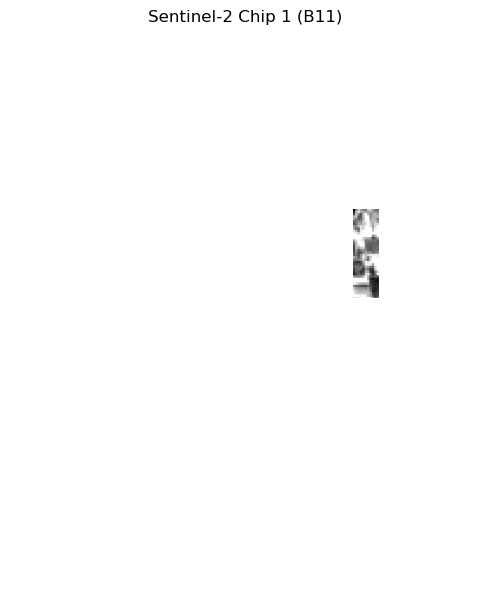

In [30]:
import matplotlib.pyplot as plt

# Check if chips exist
if not chip_dict:
    print("No chips were saved. Check for errors in processing.")
else:
    first_location = next(iter(chip_dict.keys()))  # Get first (i, j) key
    first_four_chips = chip_dict[first_location][:4]  # Get first 4 chips

    num_chips = len(first_four_chips)
    fig, axes = plt.subplots(2, num_chips, figsize=(5 * num_chips, 6))

    for idx, (s2_chip, lc_chip) in enumerate(first_four_chips):
        if s2_chip is None or lc_chip is None:
            print(f"Skipping chip {idx+1}: Missing data.")
            continue

        # Adjust indexing for single-chip cases
        if num_chips == 1:
            ax_s2, ax_lc = axes  # Unpack single-row axes
        else:
            ax_s2, ax_lc = axes[:, idx]  # Use both subplots for each chip

        ###  Fix Sentinel-2 Image Display ###
        try:
            available_bands = s2_chip.coords["band"].values  
            print(f"Available bands in chip {idx+1}: {available_bands}")

            # If standard RGB bands aren't available, select one available band
            if all(b not in available_bands for b in [4, 3, 2]):
                print(f" Chip {idx+1} has no valid RGB bands. Displaying single-band.")
                selected_band = "B11" if "B11" in available_bands else available_bands[0]
                s2_chip = s2_chip.sel(band=selected_band)
                rgb_image = s2_chip.compute() if s2_chip.chunks else s2_chip
                cmap = "gray"
            else:
                selected_bands = [b for b in [4, 3, 2] if b in available_bands]
                rgb_image = s2_chip.sel(band=selected_bands).transpose("y", "x", "band")
                rgb_image = rgb_image.compute() if rgb_image.chunks else rgb_image
                cmap = None

            # Ensure correct shape
            if len(rgb_image.shape) == 3 and rgb_image.shape[0] == 1:
                rgb_image = rgb_image.squeeze(0)  

            ax_s2.imshow(rgb_image.clip(0, 3000) / 3000, cmap=cmap)
            ax_s2.set_title(f"Sentinel-2 Chip {idx+1} ({selected_band})")
            ax_s2.axis("off")

        except Exception as e:
            print(f"Error visualizing Sentinel-2 chip {idx+1}: {e}")
            ax_s2.axis("off")

        ### Fix Land Cover Image Display ###
        try:
            lc_data = lc_chip.compute() if lc_chip.chunks else lc_chip

            # Ensure correct shape
            if len(lc_data.shape) == 3 and lc_data.shape[0] == 1:
                lc_data = lc_data.squeeze(0)

            ax_lc.imshow(lc_data, cmap="tab10")  
            ax_lc.set_title(f"Land Cover Chip {idx+1}")
            ax_lc.axis("off")

        except Exception as e:
            print(f"Error visualizing Land Cover chip {idx+1}: {e}")
            ax_lc.axis("off")

    plt.tight_layout()
    plt.show()



Available bands in chip 1: ['B11' 'B12']
⚠️ Chip 1 has no valid RGB bands. Displaying as grayscale.
Error visualizing Sentinel-2 chip 1: Invalid shape (2, 224, 224) for image data
Error visualizing Land Cover chip 1: Invalid shape (1, 224, 224) for image data


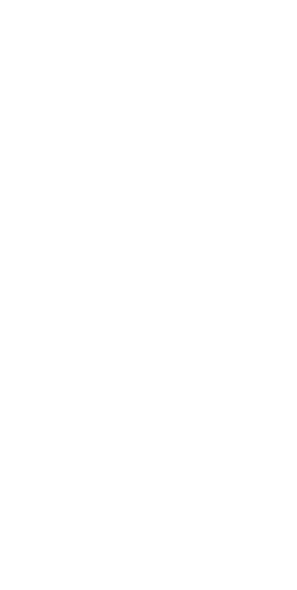

In [29]:
import matplotlib.pyplot as plt

# Check if chips exist
if not chip_dict:
    print("No chips were saved. Check for errors in processing.")
else:
    first_location = next(iter(chip_dict.keys()))  # Get first (i, j) key
    first_four_chips = chip_dict[first_location][:4]  # Get first 4 chips

    num_chips = len(first_four_chips)
    fig, axes = plt.subplots(2, num_chips, figsize=(5 * num_chips, 6))

    for idx, (s2_chip, lc_chip) in enumerate(first_four_chips):
        if s2_chip is None or lc_chip is None:
            print(f"Skipping chip {idx+1}: Missing data.")
            continue

        # Adjust indexing for single-chip cases
        if num_chips == 1:
            ax_s2, ax_lc = axes  # Unpack single-row axes
        else:
            ax_s2, ax_lc = axes[:, idx]  # Use both subplots for each chip

        try:
            print(f"Available bands in chip {idx+1}: {s2_chip.coords['band'].values}")

            desired_bands = [4, 3, 2]
            valid_bands = s2_chip.coords["band"].values
            selected_bands = [b for b in desired_bands if b in valid_bands]

            if selected_bands:
                rgb_image = s2_chip.sel(band=selected_bands).transpose("y", "x", "band")
            else:
                print(f"⚠️ Chip {idx+1} has no valid RGB bands. Displaying as grayscale.")
                rgb_image = s2_chip  # Use as grayscale

            rgb_image = rgb_image.compute() if rgb_image.chunks else rgb_image
            ax_s2.imshow(rgb_image.clip(0, 3000) / 3000, cmap="gray" if "band" not in s2_chip.dims else None)
            ax_s2.set_title(f"Sentinel-2 Chip {idx+1}")
            ax_s2.axis("off")

        except Exception as e:
            print(f"Error visualizing Sentinel-2 chip {idx+1}: {e}")
            ax_s2.axis("off")

        # Land Cover Visualization
        try:
            lc_data = lc_chip.compute() if lc_chip.chunks else lc_chip
            ax_lc.imshow(lc_data, cmap="tab10")  
            ax_lc.set_title(f"Land Cover Chip {idx+1}")
            ax_lc.axis("off")
        except Exception as e:
            print(f"Error visualizing Land Cover chip {idx+1}: {e}")
            ax_lc.axis("off")

    plt.tight_layout()
    plt.show()


In [19]:
print(chip_dict)

{}
